In [37]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import pickle
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', 200)

<h1> Load the Data </h1>

In [2]:
# function to read raw text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        
        # read all text
        text = file.read()
        file.close()
        return text

In [3]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [5]:
data = read_text("data/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

In [7]:
deu_eng = deu_eng[:50000,:]

<ul>
    <li style="font-size:150%;">The actual data contains over 150,000 sentence-pairs. However, we will use only the first 50,000 sentence pairs to reduce the training time of the model. You can change this number as per your system’s computation power.</li>
</ul>

<h1> Text Cleaning / Preprocessing</h1>

<ul>
    <li style="font-size:150%;">We will get rid of the punctuation marks and then convert all the text to lower case.</li>
</ul>

In [8]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

deu_eng

array([['Go', 'Geh',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi', 'Hallo',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi', 'Grüß Gott',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Im giving up smoking', 'Ich höre mit dem Rauchen auf',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #256952 (minshirui) & #407184 (MUIRIEL)'],
       ['Im glad I was nearby', 'Ich bin froh dass ich in der Nähe war',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547219 (CK) & #3448316 (Pfirsichbaeumchen)'],
       ['Im glad Tom has gone', 'Ich bin froh dass Tom weg ist',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2547217 (CK) & #5299642 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [9]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

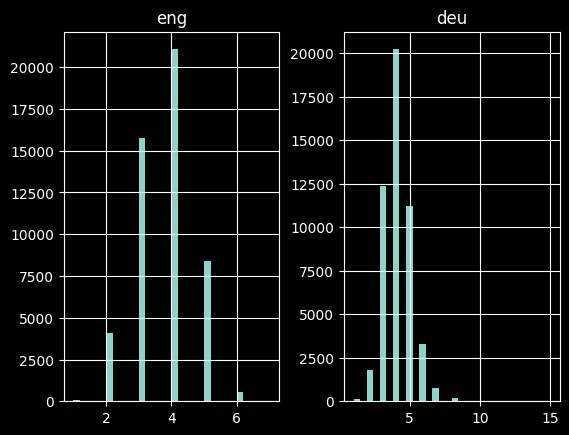

In [10]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

<ul>
    <li style="font-size:150%;">A Seq2Seq model requires that we convert both the input and the output sentences into integer sequences of fixed length.</li>
    <li style="font-size:150%;">Now, vectorize our text data by using Keras’s Tokenizer() class. It will turn our sentences into sequences of integers. We can then pad those sequences with zeros to make all the sequences of the same length.</li>
    <li style="font-size:150%;">Prepare tokenizers for both the German and English sentences</li>
</ul>

In [11]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [12]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6256


In [48]:
# save tokenizer
pickle.dump(eng_tokenizer, open('tokenizers/eng_tokenizer.pkl', 'wb'))

In [13]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10329


In [49]:
pickle.dump(deu_tokenizer, open('tokenizers/deu_tokenizer.pkl', 'wb'))

In [14]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

In [15]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

In [16]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

<h1> Define the Model</h1>

In [17]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [18]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)

In [20]:
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy')

<h1> Fit the Model</h1>

<ul>
    <li style="font-size:150%;">ModelCheckpoint() function to save the model with the lowest validation loss. I personally prefer this method over early stopping.</li>
</ul>

In [21]:
filename = 'model.keras'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=30, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/30

63/63 [==============================] - ETA: 0s - loss: 4.1039
Epoch 1: val_loss improved from inf to 3.03052, saving model to model.keras
63/63 [==============================] - 58s 828ms/step - loss: 4.1039 - val_loss: 3.0305
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 2.8810
Epoch 2: val_loss improved from 3.03052 to 2.84083, saving model to model.keras
63/63 [==============================] - 50s 802ms/step - loss: 2.8810 - val_loss: 2.8408
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 2.7590
Epoch 3: val_loss improved from 2.84083 to 2.77906, saving model to model.keras
63/63 [==============================] - 48s 767ms/step - loss: 2.7590 - val_loss: 2.7791
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 2.7019
Epoch 4: val_loss improved from 2.77906 to 2.74440, saving model to model.keras
63/63 [==============================] - 50s 798ms/step - loss: 2.7019 - val_loss: 2.7444
Epoch 5/30
63/63 [=====

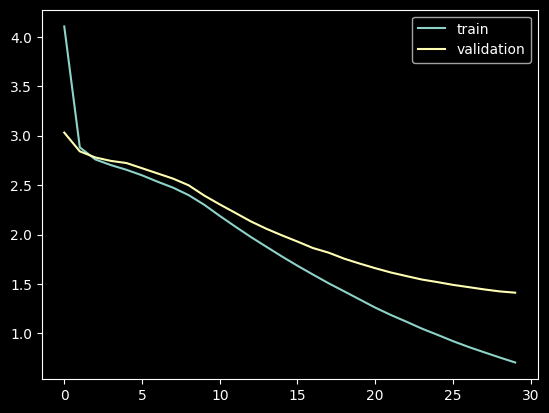

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

<h1> Prediction on unseen data</h1>

In [29]:
model = load_model('model.keras')
preds = np.argmax(model.predict(testX.reshape((testX.shape[0],testX.shape[1]))),axis=-1)

313/313 [==============================] - 9s 26ms/step


In [52]:
print('Predicted: ',preds[0])

Predicted:  [  2 219  35  13   0   0   0   0]


In [30]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [31]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [32]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [53]:
# print 15 rows randomly
pred_df.head(15)

,actual,predicted
0,i know that already,i already know that
1,whos she,who is you
2,do you have it,do you have it
3,use your feet,do you your
4,that was the trouble,the was broken
5,he took off his coat,he took his
6,tom went sightseeing,tom went at early
7,i tried on the shoes,i took the shoes
8,open those doors,open the door
9,ive got to help tom,i have to help tom


In [ ]:
def input_to_output(input_text, model, )